In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

: 

In [4]:
#Reading Data
df = pd.read_csv("C:\\Users\AmirHussain\Desktop\machine-Learning-tradert-bot-main\Datas\XAUUSDM5.csv" , 
                   encoding = 'utf-16', 
                   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )

df.drop(['0', 'Volume'], inplace= True, axis= 1)
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', drop=True, inplace = True)

In [5]:
df = zigzag(df, 1.5)
df['ma 1'] = ta.ma('sma', df['Open'], length = 13)
df['ma 2'] = ta.ma('sma', df['Open'], length = 21)
df['std']  = ta.stdev(df['Open'], 21)
df['macd'] = df['ma 1'] - df['ma 2']
df['rsi'] = ta.rsi(df['Open'], 21)

df['next'] = df['Open'].rolling(5).mean().shift(-1)
df['diff'] =  df['Open'].shift(-1) - df['Open']



df["heap"] = df["zig-zag"]

for i in df.index:
    if  df["Open"][i] == df["zig-zag"][i]:
        df.loc[i, 'heap'] = df["Open"][i]
    else:
        df.loc[i, 'heap'] = np.nan

In [6]:
back_candel = 10
df['Slope'] = df['Open'].rolling(window=back_candel).apply(lambda x: np.polyfit(np.arange(back_candel), x, 1)[0])

In [9]:
# df.dropna(inplace=True)
df = df[24:]
df.reset_index(inplace= True)
df.head()

,index,Date,Open,High,Low,Close,zig-zag,ma 1,ma 2,std,macd,rsi,next,diff,heap,Slope,moving
0,24,2021-12-23 17:05:00,1804.47,1806.15,1803.35,1806.11,1804.47,1803.952308,1805.460952,2.827877,-1.508645,48.126818,1803.254,1.62,1804.47,-0.425333,-767.501240
1,25,2021-12-23 17:10:00,1806.09,1806.37,1804.87,1805.43,1806.09,1803.864615,1805.410476,2.805593,-1.545861,53.842402,1804.068,-0.61,1806.09,-0.053455,-96.543720
2,26,2021-12-23 17:15:00,1805.48,1806.49,1805.01,1805.65,1806.09,1803.840000,1805.286190,2.737953,-1.446190,51.594758,1804.884,0.12,NaN,0.285152,514.835358
3,27,2021-12-23 17:20:00,1805.60,1805.72,1804.36,1805.17,1806.09,1803.831538,1805.086190,2.537831,-1.254652,52.008574,1805.360,-0.44,NaN,0.604061,1090.691830
4,28,2021-12-23 17:25:00,1805.16,1806.39,1804.98,1805.42,1806.09,1803.726154,1804.899048,2.366973,-1.172894,50.351330,1805.558,0.30,NaN,0.705030,1272.692502


In [14]:
df['buy'] =  (   (df['heap'] != np.nan)   ).astype(int)
df['sell'] = (   (df['heap'] != np.nan ) ).astype(int)

df['signal'] = df.apply(lambda row: 0 if row['buy']  else (1 if row['sell'] else 2), axis=1)

df['signal'] = df['signal'].shift(1)

In [15]:
df['signal'].value_counts()  

signal
0.0    99975
Name: count, dtype: int64

In [ ]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(10)

KeyError: 'signal'

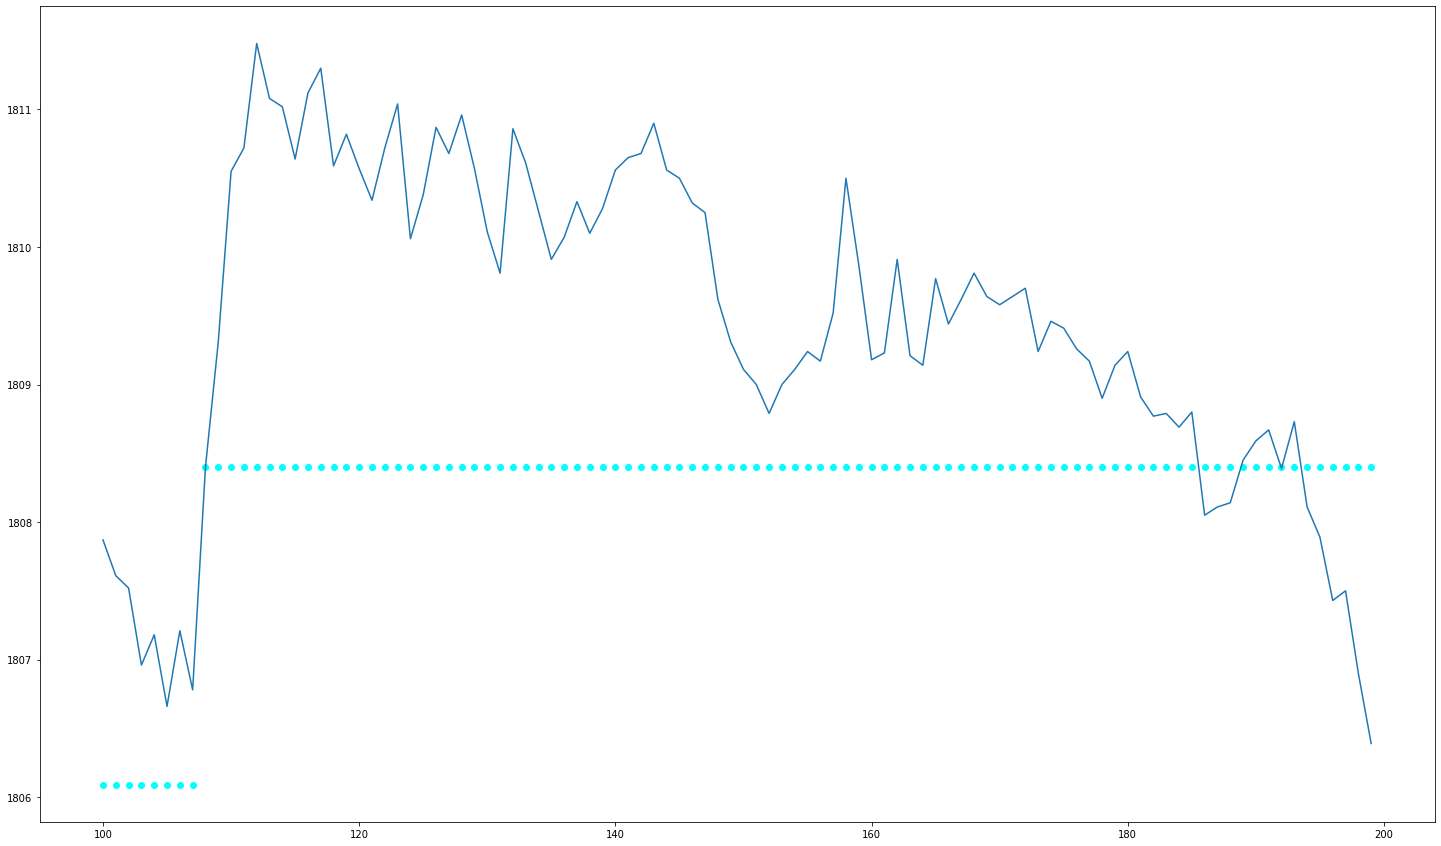

In [10]:
fig = plt.figure(figsize=(25,15))
plt.plot( df['Open'][100: 200]     , label = "Open")

plt.scatter( df.index[100: 200 ], df['zig-zag'][100: 200]  ,c= 'cyan'  , label = "zig-zag")

for i in df.index[100: 200 ]:
    if df["signal"][i] == 0:
        plt.scatter(i, df["Open"][i], c = 'green')
    if df["signal"][i] == 1:
        plt.scatter(i, df["Open"][i], c = 'red')
plt.legend()
plt.grid()
plt.show()

In [ ]:
m1 = pd.read_csv("C:\\Users\AmirHussain\Desktop\machine-Learning-tradert-bot-main\Datas\XAUUSDM1.csv" , 
                   encoding = 'utf-16', 
                   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )
m1['next'] = m1['Open'].shift(-1)
m1['diff'] =  m1['next'] - m1['Open']
Long = 0
Shorts = 0
Amount = 100
journal = {}
stop_loss = Amount * (1 / 100)  # Set your desired stop loss level
take_profit =  Amount * (1 / 100)  # Set your desired take profit level

for i in range(len(df)):
    if df['signal'][i] == 0:
        position = 0
        Long += 1
        j = 0
        position += m1['diff'][i]
        while position <= take_profit and position >= -stop_loss:
            if i + j >= len(df):
                break
            position += m1['diff'][i + j]
            j += 1
        journal[f"Long {Long}"] = position
        Amount += position
        position = 0
        j = 0

    elif df['signal'][i] == 1:
        position = 0
        Shorts += 1
        j = 0
        position += (-1 * m1['diff'][i])
        while position <= take_profit and position >= -stop_loss:
            if i + j >= len(df):
                break
            position += (-1 * m1['diff'][i + j])
            j += 1

        journal[f"short {Shorts}"] = position
        Amount += position
        position = 0
        j = 0

print("Long Pos: ", Long)
print("Short Pos: ", Shorts)
print("All amount: ", Amount)


Long Pos:  2548
Short Pos:  6868
All amount:  382.69000000000005


In [ ]:
X = df[ [ 'rsi', 'std',  'macd' ] ]
X = X.to_numpy()
Y = df[ "signal"  ]
Y = Y.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split( X,
                                                     Y, 
                                                     test_size= 0.30,
                                                     shuffle = False)


# K-nearset nighbor